## Set up

In [2]:
from pathlib import Path
from tempfile import mkdtemp
from shutil import rmtree
import sys
import itertools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours

In [5]:
# Enable imports from the parent directory
parent_dir = '..'
sys.path.append(parent_dir)

In [6]:
from utils import draw_pr_curve_from_cv_results

In [7]:
sns.set_theme(context='notebook', style='whitegrid', palette='muted')

In [8]:
cachedir = mkdtemp()

In [9]:
data_dir = Path('../../results')
train = pd.read_csv(data_dir / 'train_clean.csv')

In [10]:
train.columns

Index(['originalTitle', 'rating', 'startYear', 'runtimeMinutes', 'numVotes',
       'totalImages', 'totalCredits', 'titleType', 'canHaveEpisodes',
       'numRegions', 'countryOfOrigin', 'genres', 'companiesNumber',
       'averageRating', 'regions', 'externalLinks', 'writerCredits',
       'aggrTitleType', 'numGenres', 'criticReviewsRatio', 'hasAwards',
       'hasAwardsOrNominations', 'hasVideos', 'hasCriticsReviews',
       'hasUserReviews', 'moreDirectorsCredits', 'hasQuotes',
       'moreCountriesOfOrigin'],
      dtype='object')

In [11]:
num_cols = train.dtypes[(train.dtypes == 'float64') | (train.dtypes == 'int64')].index
target_feat = 'hasAwards'

In [12]:
train_X, train_y = train[num_cols], train[target_feat]

The target feature is sufficiently unbalanced.

In [13]:
train_y.value_counts() / train_y.shape[0]

hasAwards
False    0.918444
True     0.081556
Name: count, dtype: float64

In [14]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [15]:
pipeline = Pipeline([
    ('sampler', None),
    ('scaler', RobustScaler()),
    ('clf', KNeighborsClassifier())
], memory=cachedir)

In [16]:
param_grid = {
    'clf__n_neighbors': np.arange(1, 21, 2),
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean']
}

In [17]:
best_estimators = dict()
cv_results = dict()

## No strategy

We initally performed random search with odd k between 1 and 100, but since we saw that performance decreased for all methods for higher values of k, we decided to perform grid search with odd k between 1 and 21. 

In [18]:
%%time
grid = GridSearchCV(
    pipeline, param_grid=param_grid,
    scoring='f1', n_jobs=-1, cv=splitter, verbose=1,
    pre_dispatch='1*n_jobs')
grid.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 805 ms, sys: 243 ms, total: 1.05 s
Wall time: 2min 45s


,estimator,Pipeline(memo...lassifier())])
,param_grid,"{'clf__metric': ['euclidean'], 'clf__n_neighbors': array([ 1, 3..., 15, 17, 19]), 'clf__weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'1*n_jobs'
,error_score,nan
,return_train_score,False
,with_centering,True


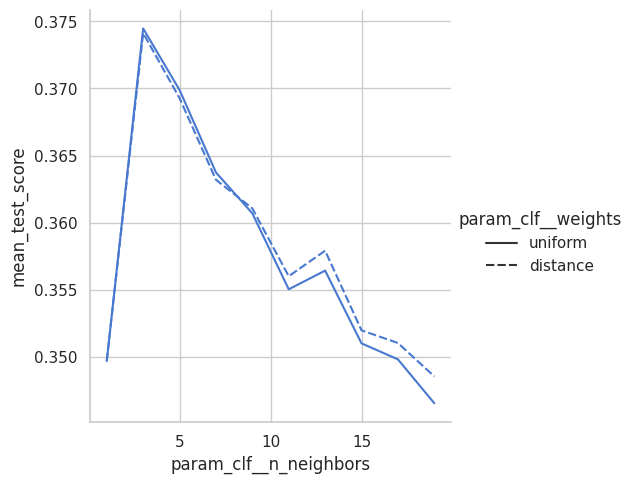

In [19]:
results = pd.DataFrame(grid.cv_results_)
sns.relplot(results, x='param_clf__n_neighbors', y='mean_test_score', style='param_clf__weights', kind='line')

In [20]:
best_estimators["No strategy"] = grid.best_estimator_
cv_results['No strategy'] = cross_validate(grid.best_estimator_, train_X, train_y,
                             scoring=('accuracy', 'precision', 'recall', 'f1', 'average_precision'),
                             return_estimator=True, return_indices=True,
                             cv=splitter, n_jobs=-1)
print(grid.best_params_)

{'clf__metric': 'euclidean', 'clf__n_neighbors': np.int64(3), 'clf__weights': 'uniform'}


In [21]:
for key, value in cv_results['No strategy'].items():
    if key.startswith('test'):
        print(f"mean {key.replace('test_', '')}: {np.mean(value):0.2f} ({np.std(value):0.2f})")

mean accuracy: 0.92 (0.00)
mean precision: 0.47 (0.02)
mean recall: 0.31 (0.01)
mean f1: 0.37 (0.01)
mean average_precision: 0.29 (0.01)


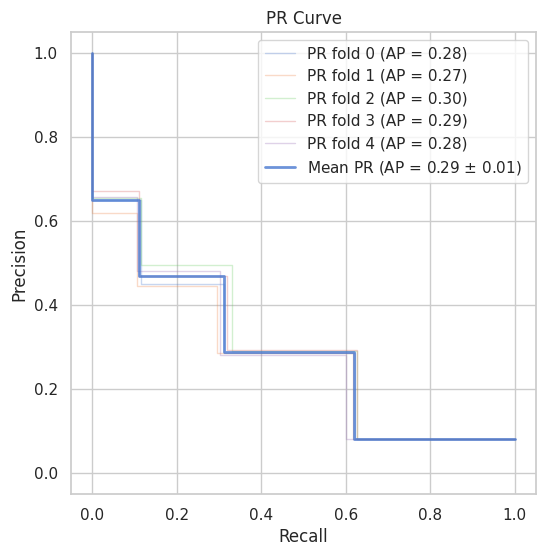

In [22]:
draw_pr_curve_from_cv_results(cv_results['No strategy'], train_X, train_y)

## Oversampling

In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

### Random Oversampling

In [24]:
pipeline.set_params(sampler=RandomOverSampler())

,steps,"[('sampler', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,'/tmp/tmpz9eem5s_'
,verbose,False
,sampling_strategy,'auto'
,random_state,None
,shrinkage,None
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True


In [25]:
%%time
grid = GridSearchCV(
    pipeline, param_grid=param_grid,
    scoring='f1', n_jobs=-1, cv=splitter, verbose=1,
    pre_dispatch='1*n_jobs')
grid.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 1.28 s, sys: 310 ms, total: 1.59 s
Wall time: 3min 15s


,estimator,Pipeline(memo...lassifier())])
,param_grid,"{'clf__metric': ['euclidean'], 'clf__n_neighbors': array([ 1, 3..., 15, 17, 19]), 'clf__weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'1*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


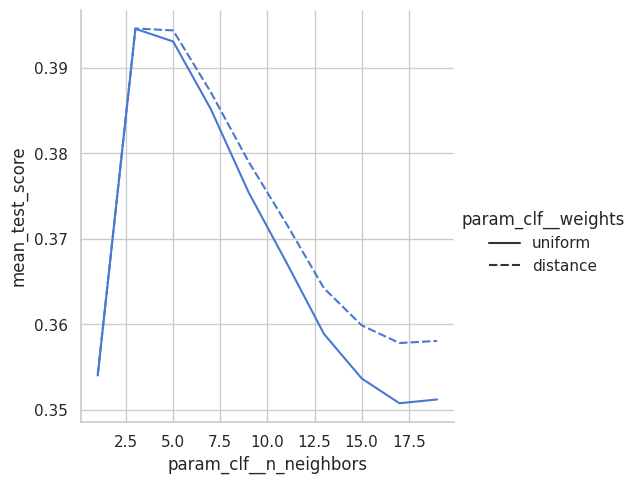

In [26]:
results = pd.DataFrame(grid.cv_results_)
sns.relplot(results, x='param_clf__n_neighbors', y='mean_test_score', style='param_clf__weights', kind='line')

In [27]:
best_estimators['Random Oversampling'] = grid.best_estimator_
cv_results['Random Oversampling'] = cross_validate(grid.best_estimator_, train_X, train_y,
                             scoring=('accuracy', 'precision', 'recall', 'f1', 'average_precision'),
                             return_estimator=True, return_indices=True,
                             cv=splitter, n_jobs=-1)

print(grid.best_params_)

{'clf__metric': 'euclidean', 'clf__n_neighbors': np.int64(3), 'clf__weights': 'distance'}


In [28]:
for key, value in cv_results['Random Oversampling'].items():
    if key.startswith('test'):
        print(f"mean {key.replace('test_', '')}: {np.mean(value):0.2f} ({np.std(value):0.2f})")

mean accuracy: 0.87 (0.00)
mean precision: 0.32 (0.01)
mean recall: 0.52 (0.01)
mean f1: 0.39 (0.01)
mean average_precision: 0.24 (0.01)


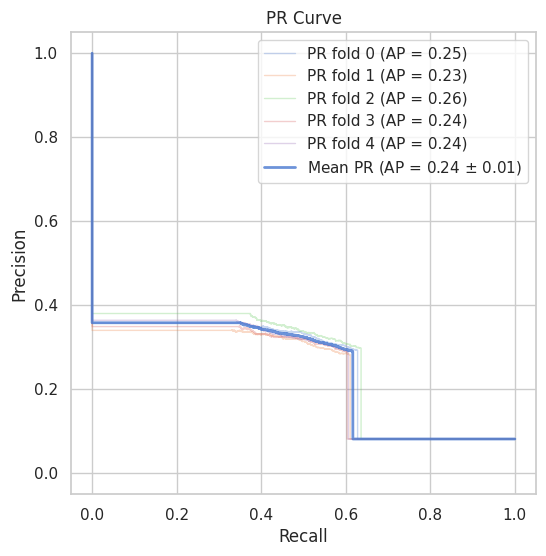

In [29]:
draw_pr_curve_from_cv_results(cv_results['Random Oversampling'], train_X, train_y)

### SMOTE

In [30]:
pipeline.set_params(sampler=SMOTE())

,steps,"[('sampler', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,'/tmp/tmpz9eem5s_'
,verbose,False
,sampling_strategy,'auto'
,random_state,None
,k_neighbors,5
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True


In [31]:
%%time
grid = GridSearchCV(
    pipeline, param_grid=param_grid,
    scoring='f1', n_jobs=-1, cv=splitter, verbose=1,
    pre_dispatch=2)
grid.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 6.29 s, sys: 713 ms, total: 7 s
Wall time: 8min 38s


,estimator,Pipeline(memo...lassifier())])
,param_grid,"{'clf__metric': ['euclidean'], 'clf__n_neighbors': array([ 1, 3..., 15, 17, 19]), 'clf__weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,2
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


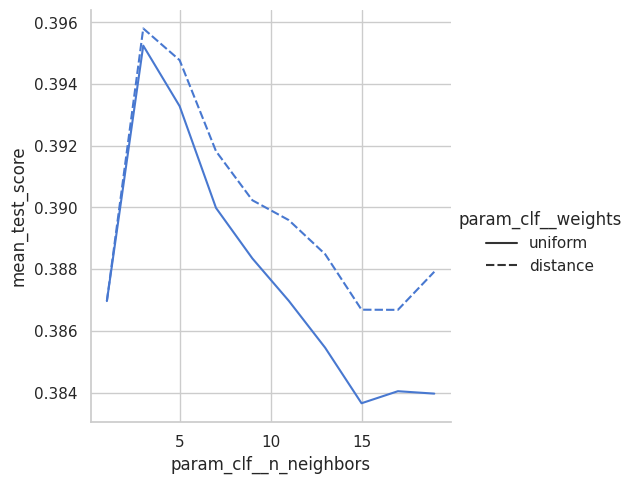

In [32]:
results = pd.DataFrame(grid.cv_results_)
sns.relplot(results, x='param_clf__n_neighbors', y='mean_test_score', style='param_clf__weights', kind='line')

In [33]:
best_estimators['SMOTE'] = grid.best_estimator_
cv_results['SMOTE'] = cross_validate(grid.best_estimator_, train_X, train_y,
                             scoring=('accuracy', 'precision', 'recall', 'f1', 'average_precision'),
                             return_estimator=True, return_indices=True,
                             cv=splitter, n_jobs=-1)
print(grid.best_params_)

{'clf__metric': 'euclidean', 'clf__n_neighbors': np.int64(3), 'clf__weights': 'distance'}


In [34]:
for key, value in cv_results['SMOTE'].items():
    if key.startswith('test'):
        print(f"mean {key.replace('test_', '')}: {np.mean(value):0.2f} ({np.std(value):0.2f})")

mean accuracy: 0.84 (0.00)
mean precision: 0.28 (0.00)
mean recall: 0.66 (0.01)
mean f1: 0.40 (0.01)
mean average_precision: 0.27 (0.01)


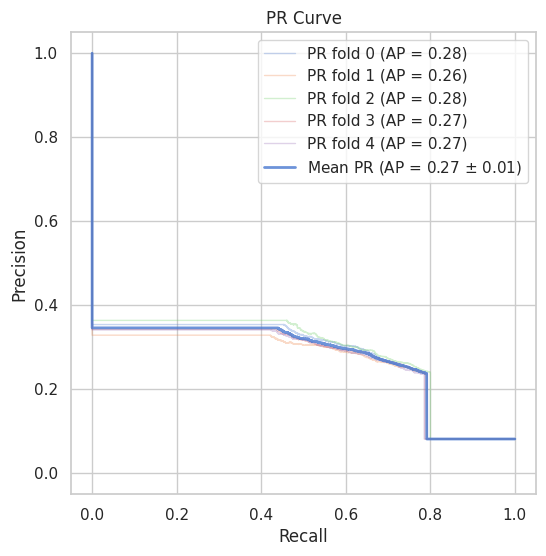

In [35]:
draw_pr_curve_from_cv_results(cv_results['SMOTE'], train_X, train_y)

## Undersampling

### Random Undersampling

In [36]:
pipeline.set_params(sampler=RandomUnderSampler())

,steps,"[('sampler', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,'/tmp/tmpz9eem5s_'
,verbose,False
,sampling_strategy,'auto'
,random_state,None
,replacement,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True


In [37]:
%%time
grid = GridSearchCV(
    pipeline, param_grid=param_grid,
    scoring='f1', n_jobs=-1, cv=splitter, verbose=1,
    pre_dispatch='1*n_jobs')
grid.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 335 ms, sys: 72.1 ms, total: 407 ms
Wall time: 32.9 s


,estimator,Pipeline(memo...lassifier())])
,param_grid,"{'clf__metric': ['euclidean'], 'clf__n_neighbors': array([ 1, 3..., 15, 17, 19]), 'clf__weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'1*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


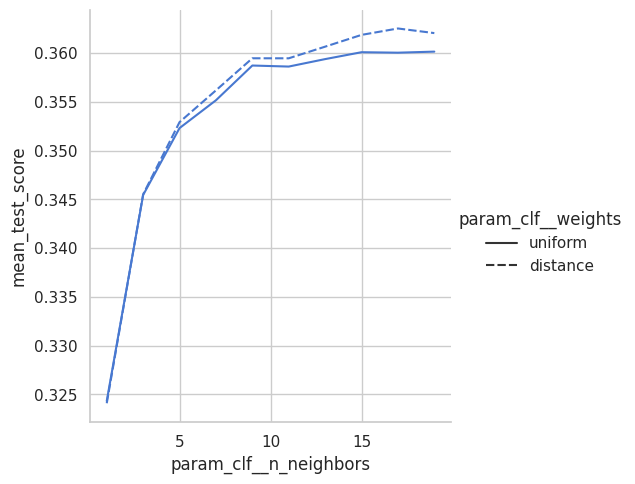

In [38]:
results = pd.DataFrame(grid.cv_results_)
sns.relplot(results, x='param_clf__n_neighbors', y='mean_test_score', style='param_clf__weights', kind='line')

In [39]:
best_estimators['Random Undersampling'] = grid.best_estimator_
cv_results['Random Undersampling'] = cross_validate(grid.best_estimator_, train_X, train_y,
                             scoring=('accuracy', 'precision', 'recall', 'f1', 'average_precision'),
                             return_estimator=True, return_indices=True,
                             cv=splitter, n_jobs=-1)
print(grid.best_params_)

{'clf__metric': 'euclidean', 'clf__n_neighbors': np.int64(17), 'clf__weights': 'distance'}


In [40]:
for key, value in cv_results['Random Undersampling'].items():
    if key.startswith('test'):
        print(f"mean {key.replace('test_', '')}: {np.mean(value):0.2f} ({np.std(value):0.2f})")

mean accuracy: 0.76 (0.00)
mean precision: 0.23 (0.00)
mean recall: 0.85 (0.01)
mean f1: 0.36 (0.00)
mean average_precision: 0.42 (0.01)


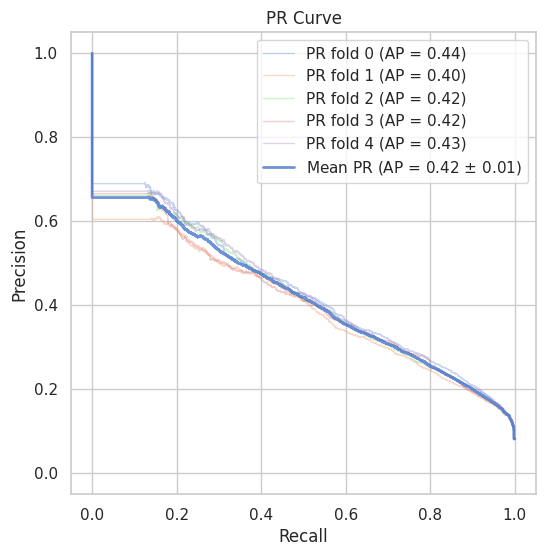

In [41]:
draw_pr_curve_from_cv_results(cv_results['Random Undersampling'], train_X, train_y)

### Edited Nearest Neighbor

In [42]:
pipeline.set_params(sampler=EditedNearestNeighbours())

,steps,"[('sampler', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,'/tmp/tmpz9eem5s_'
,verbose,False
,sampling_strategy,'auto'
,n_neighbors,3
,kind_sel,'all'
,n_jobs,None
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [43]:
%%time
grid = GridSearchCV(
    pipeline, param_grid=param_grid,
    scoring='f1', n_jobs=-1, cv=splitter, verbose=1,
    pre_dispatch=3)
grid.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 24.2 s, sys: 423 ms, total: 24.6 s
Wall time: 5min 22s


,estimator,Pipeline(memo...lassifier())])
,param_grid,"{'clf__metric': ['euclidean'], 'clf__n_neighbors': array([ 1, 3..., 15, 17, 19]), 'clf__weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,3
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


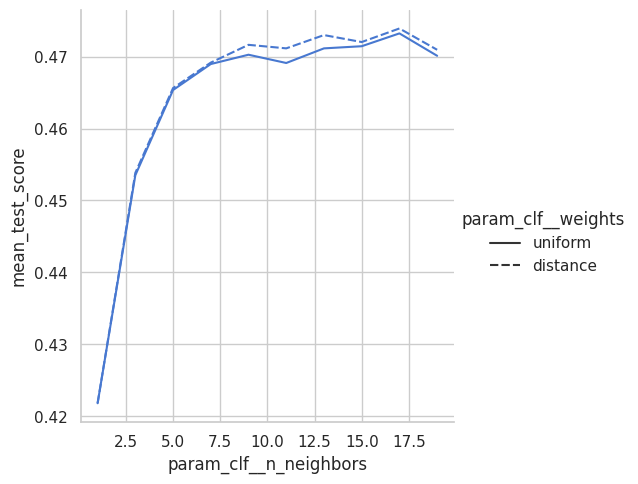

In [44]:
results = pd.DataFrame(grid.cv_results_)
sns.relplot(results, x='param_clf__n_neighbors', y='mean_test_score', style='param_clf__weights', kind='line')

In [45]:
best_estimators['Edited NN'] = grid.best_estimator_
cv_results['Edited NN'] = cross_validate(grid.best_estimator_, train_X, train_y,
                             scoring=('accuracy', 'precision', 'recall', 'f1', 'average_precision'),
                             return_estimator=True, return_indices=True,
                             cv=splitter, n_jobs=-1)
print(grid.best_params_)

{'clf__metric': 'euclidean', 'clf__n_neighbors': np.int64(17), 'clf__weights': 'distance'}


In [46]:
for key, value in cv_results['Edited NN'].items():
    if key.startswith('test'):
        print(f"mean {key.replace('test_', '')}: {np.mean(value):0.2f} ({np.std(value):0.2f})")

mean accuracy: 0.92 (0.00)
mean precision: 0.49 (0.00)
mean recall: 0.46 (0.01)
mean f1: 0.47 (0.00)
mean average_precision: 0.47 (0.01)


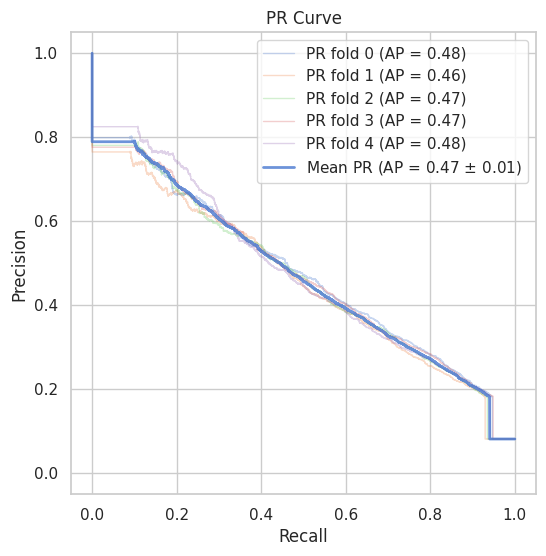

In [47]:
draw_pr_curve_from_cv_results(cv_results['Edited NN'], train_X, train_y)

## Comparison

CPU times: user 2min 29s, sys: 612 ms, total: 2min 29s
Wall time: 2min 30s


Text(0.5, 1.0, 'Precision-Recall curves on 5-fold cross validation')

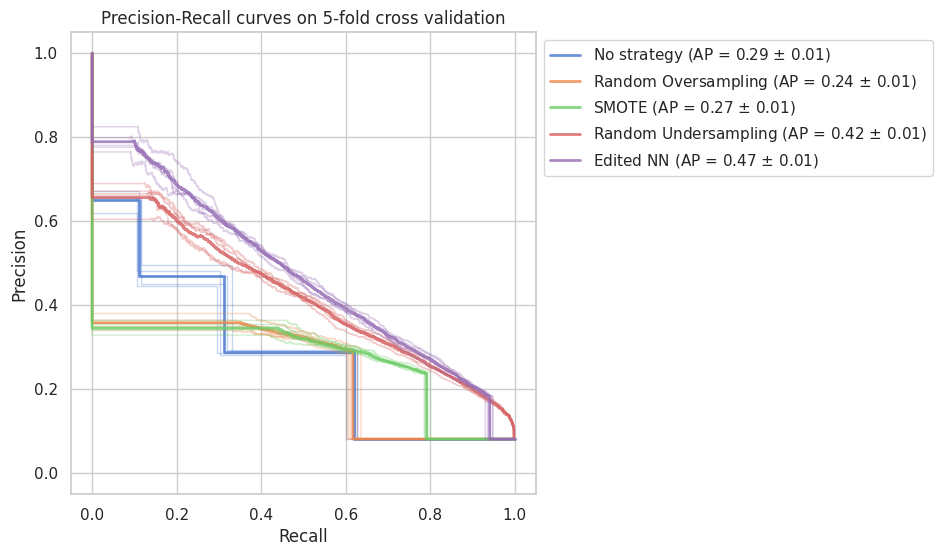

In [48]:
%%time
palette = itertools.cycle(sns.color_palette())

fig, ax = plt.subplots(figsize=(6, 6))
for name, results in cv_results.items():
    draw_pr_curve_from_cv_results(results, train_X, train_y, name=name, ax=ax, color=next(palette))
ax.set_title('Precision-Recall curves on 5-fold cross validation')

In [49]:
fig.savefig(data_dir / 'images' / 'imb_learn_cv_pr.png', bbox_inches='tight')

Export table of results on cross-validation

In [50]:
cv_results_aggr = {
    estimator: {
        key.replace('test_', '').replace('_', ' '):
        r"%0.2f $\pm$ %0.2f" %(np.mean(value), np.std(value))
        for key, value
        in results.items()
        if key.startswith('test')
    }
    for estimator, results
    in cv_results.items()
}
pd.DataFrame(cv_results_aggr).transpose().to_csv(data_dir / 'tables' / 'imb_learn_cv_performance.csv', index_label='Resampling Method')

## Tear down

In [51]:
try:
    rmtree(cachedir)
except FileNotFoundError:
    pass